# Step 3. Baseline Model

[//]: # (TODO: Write methodology and observations here)

In [1]:
# Imports and environmental setups

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Custom utils functions
from utils import dataset
from utils.visualization import plot_learning_curve
from utils.visualization import visualize_predictions


plt.style.use('ggplot')
dataset_dir = '../data/processed/'
log_dir = '../log/baseline/'

## 3.1. Load Dataset

In [2]:
df = dataset.load(dataset_dir)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16344 entries, 0 to 16343
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ImgPath       16344 non-null  object 
 1   FileType      16344 non-null  object 
 2   Width         16344 non-null  int64  
 3   Height        16344 non-null  int64  
 4   Ratio         16344 non-null  float64
 5   Mode          16344 non-null  object 
 6   Bands         16344 non-null  object 
 7   Transparency  16344 non-null  bool   
 8   Animated      16344 non-null  bool   
 9   Class         16344 non-null  object 
dtypes: bool(2), float64(1), int64(2), object(5)
memory usage: 1.0+ MB


In [4]:
df.sample(n=42, random_state=42)

,ImgPath,FileType,Width,Height,Ratio,Mode,Bands,Transparency,Animated,Class
15728,Tana/tana_105.jpg,jpg,512,512,1.0,RGB,R G B,False,False,Tana
10549,Pingpong/000279.jpg,jpg,512,512,1.0,RGB,R G B,False,False,Pingpong
476,Baby/000477.jpg,jpg,512,512,1.0,RGB,R G B,False,False,Baby
13796,Rosy/001504.jpg,jpg,512,512,1.0,RGB,R G B,False,False,Rosy
9416,Lisianthus/lisianthus_201.jpg,jpg,512,512,1.0,RGB,R G B,False,False,Lisianthus
10843,Pingpong/000573.jpg,jpg,512,512,1.0,RGB,R G B,False,False,Pingpong
12634,Rosy/000342.jpg,jpg,512,512,1.0,RGB,R G B,False,False,Rosy
11220,Pingpong/000950.jpg,jpg,512,512,1.0,RGB,R G B,False,False,Pingpong
15794,Tana/tana_165.jpg,jpg,512,512,1.0,RGB,R G B,False,False,Tana
4526,Chrysanthemum/000446.jpg,jpg,512,512,1.0,RGB,R G B,False,False,Chrysanthemum


In [5]:
train, test = train_test_split(df, shuffle=True, test_size=0.2, random_state=42)
train, val = train_test_split(train, shuffle=True, test_size=0.25, random_state=42)

print(f'Train data: {train.shape[0]} samples, Validation Data: {val.shape[0]} samples, Test Data: {test.shape[0]} samples.')

Train data: 9806 samples, Validation Data: 3269 samples, Test Data: 3269 samples.


## 3.2. Baseline Model Setup and Training

### 3.2.1. Baseline Parameters

In [6]:
# Model Parameters
IMG_SIZE = 256
BATCH_SIZE = 512
INPUT_DIM = (IMG_SIZE, IMG_SIZE, 3)  # RGB - 3 channels
HIDDEN_LAYER_DIM = 64
OUTPUT_CLASSES = 8  # One-hot encoded: 8 different classes

# Training Parameters
EPOCHS = 24
LEARNING_RATE = 1e-3

### 3.2.2. Model Setup

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
], name='baseline')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 128)               25165952  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 25,216,520
Trainable params: 25,216,520
No

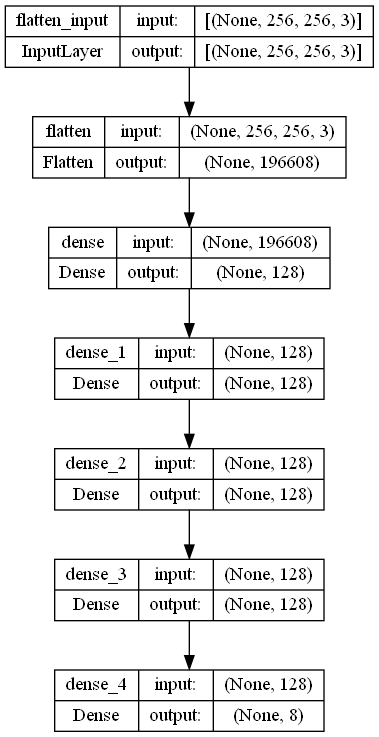

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='images/BaselineModel-Diagram.png')

### 3.2.3. Training

In [9]:
train['Class'] = train['Class'].astype('str')
train_datagen = ImageDataGenerator(data_format='channels_last')
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=dataset_dir,
    x_col='ImgPath',
    y_col='Class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

val['Class'] = val['Class'].astype('str')
val_datagen = ImageDataGenerator(data_format='channels_last')
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val,
    directory=dataset_dir,
    x_col='ImgPath',
    y_col='Class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

Found 9806 validated image filenames belonging to 8 classes.
Found 3269 validated image filenames belonging to 8 classes.


In [10]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'],
)

history = model.fit(
    train_generator, validation_data=val_generator,
    epochs=EPOCHS,
    verbose=2, callbacks=[tensorboard_callback]
)

Epoch 1/24
77/77 - 35s - loss: 2.1161 - categorical_accuracy: 0.1234 - val_loss: 2.0960 - val_categorical_accuracy: 0.1282 - 35s/epoch - 461ms/step
Epoch 2/24
77/77 - 36s - loss: 2.0833 - categorical_accuracy: 0.1276 - val_loss: 2.0839 - val_categorical_accuracy: 0.1205 - 36s/epoch - 462ms/step
Epoch 3/24
77/77 - 34s - loss: 2.0845 - categorical_accuracy: 0.1238 - val_loss: 2.0816 - val_categorical_accuracy: 0.1282 - 34s/epoch - 447ms/step
Epoch 4/24
77/77 - 36s - loss: 2.0832 - categorical_accuracy: 0.1255 - val_loss: 2.0812 - val_categorical_accuracy: 0.1233 - 36s/epoch - 463ms/step
Epoch 5/24
77/77 - 36s - loss: 2.0829 - categorical_accuracy: 0.1238 - val_loss: 2.0807 - val_categorical_accuracy: 0.1355 - 36s/epoch - 466ms/step
Epoch 6/24
77/77 - 37s - loss: 2.0822 - categorical_accuracy: 0.1232 - val_loss: 2.0838 - val_categorical_accuracy: 0.1205 - 37s/epoch - 484ms/step
Epoch 7/24
77/77 - 36s - loss: 2.0834 - categorical_accuracy: 0.1218 - val_loss: 2.0820 - val_categorical_accura

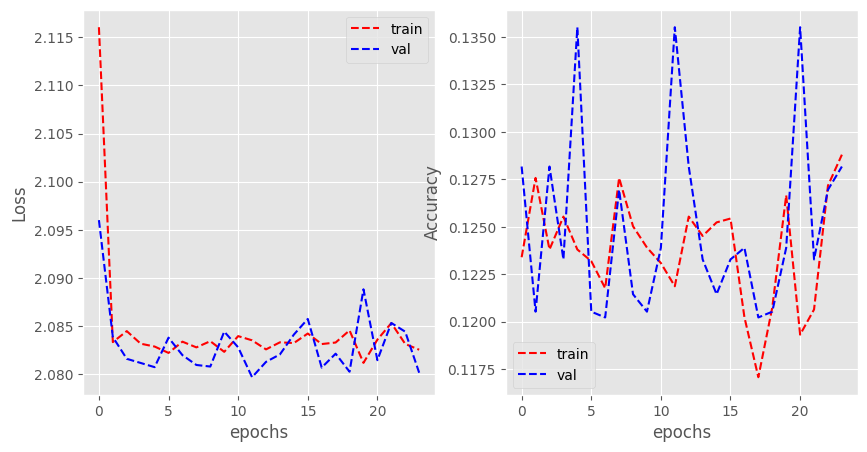

In [11]:
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['categorical_accuracy'],
    history.history['val_categorical_accuracy'],
    to_file='images/BaselineModel-LearningCurve.png'
)

## 3.3. Baseline Model Performance

In [12]:
test['Class'] = test['Class'].astype('str')
test_datagen = ImageDataGenerator(data_format='channels_last')
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=dataset_dir,
    x_col='ImgPath',
    y_col='Class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    seed=42
)

model.evaluate(test_generator)

Found 3269 validated image filenames belonging to 8 classes.
3269/3269 [==============================] - 37s 11ms/step - loss: 2.0808 - categorical_accuracy: 0.1245


[2.0807743072509766, 0.12450290471315384]

In [13]:
visualize_predictions(test_generator.labels, model, test_generator, to_file='images/BaselineModel-SamplePredictions.png')

TypeError: 'int' object does not support item assignment